### Titanic_Dataset_Improvised_Model

 building a predictive model, namely a decision tree.

The pipeline consists of several steps:

1. Exploratory Data Analysis (EDA) - understanding the data and the underlying interactions between the different variables
1. Data Pre-processing - preparing the data for modelling
1. Building the model
1. Evaluating the performance of the model, and possibly fine-tune and tweak it if necessary

The goal of the model is to predict whether a passenger survived the Titanic disaster, given their age, class and a few other features.

### Loading Libraries

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
titanic = pd.read_csv('https://raw.githubusercontent.com/dphi-official/First_ML_Model/master/titanic.csv')

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
round(len(titanic[titanic['Survived']==1])/len(titanic),2) # 38% of the people survived

0.38

In [5]:
len(titanic[(titanic['Survived'] == 1) & (titanic['Embarked'] == 'S')]) # 217 people survived from S class

217

In [6]:
titanic.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

- PassengerId - this is a just a generated Id
- Pclass - which class did the passenger ride - first, second or third
- Name - self explanatory
- Sex - male or female
- Age
- SibSp - were the passenger's spouse or siblings with them on the ship
- Parch - were the passenger's parents or children with them on the ship
- Ticket - ticket number
- Fare - ticker price
- Cabin
- Embarked - port of embarkation
- Survived - did the passenger survive the sinking of the Titanic?

Note: The whole goal is building a model that would predict the survival probability of a person, given their basic features.

### Exploratory Data Analysis (EDA)

After loading the data, let us examine it. It is usually not recommended to throw all the data into a predictive model without first understanding the data. this would often help us improving our model.

In [7]:
print('Total number of passangers in the training data...', len(titanic))
print('Number of passangers in the training data who survived...', len(titanic[titanic['Survived'] == 1]))

Total number of passangers in the training data... 891
Number of passangers in the training data who survived... 342


In [8]:
print('% of men who survived', 100*np.mean(titanic['Survived'][titanic['Sex'] == 'male']))
print('% of women who survived', 100*np.mean(titanic['Survived'][titanic['Sex'] == 'female']))

% of men who survived 18.890814558058924
% of women who survived 74.20382165605095


In [9]:
print('% of passengers who survived in first class', 100*np.mean(titanic['Survived'][titanic['Pclass'] == 1]))
print('% of passengers who survived in third class', 100*np.mean(titanic['Survived'][titanic['Pclass'] == 3]))

% of passengers who survived in first class 62.96296296296296
% of passengers who survived in third class 24.236252545824847


In [10]:
print('% of children who survived', 100*np.mean(titanic['Survived'][titanic['Age'] < 18]))
print('% of adults who survived', 100*np.mean(titanic['Survived'][titanic['Age'] > 18]))

% of children who survived 53.98230088495575
% of adults who survived 38.26086956521739


### Data Pre-processing

**Non numeric features to numeric**

In [11]:
titanic['Sex'] = titanic['Sex'].apply(lambda x: 1 if x == 'male' else 0)

The "apply" means "do that for each value in the column". the statement in the brackets should be read as following :"for every value in the column ("lambda x:") if it's a male then replace with 1, otherwise replace with 0

**Missing Values**

In [12]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
titanic['Age'] = titanic['Age'].fillna(np.mean(titanic['Age']))

In [14]:
# Looking at frequency of each values in 'Embarked'
titanic.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Filling missing values of a categorical variable with mode.

In [15]:
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN


In [16]:
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace=True)

In [17]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

**Omit irrelevant columns**

Let us only take the columns we find relevant. ID columns are never relevant (or at least should not be, if the data was sampled randomly). As our model is very simple, let us also omit the Ticket number, Cabin, ID and Name although more sophisticated models can definitely take advantage of them

In [18]:
titanic = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]

**Separating input variables (X) and target variable (y)**

In [19]:
X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

In [20]:
# !pip install sklearn

### Train and Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Building ML Model

First, we need to import our model - A decision tree classifier (again, using the sklearn library).

Then we would feed the model both with the data (X_train) and the answers for that data (y_train)

In [22]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

The training happens in the third line (the "fit" function). During the training, the algorithm is trying to build the optimal decision tree.
It tries to acheive the best score on the training data - that is, building a model that would predict the survival outcome of as many passengers as possible.

### Evaluate the model

evaulate it with using the accuracy_score function. This output of the function is the number of right answers (passengers survival/death was predicted correctly) divided by the total number of passengers

In [23]:
# !pip install graphviz

from sklearn.metrics import accuracy_score
print('Training accuracy...', accuracy_score(y_train, model.predict(X_train)))
print('Test accuracy', accuracy_score(y_test, model.predict(X_test)))

Training accuracy... 0.9798657718120806
Test accuracy 0.7254237288135593


The accuracy function compares between the actual results (our ground truth - y_train or y_test) with the prediction of the model (given by "classifier.predict(X_train)" or "classifier.predict(X_test)" respectrively.

The large difference between the training score and the test score suggets that our model overfits. That is, instead of leraning general rules that can be applied on unseen data, it does something that is more similar to memorize the training data. So our model performs really well on the training data (98% accuracy) but not remotely as well on the test data.

It is clear once we plot the tree. the next bulk of code would not be explained and can be regarded as a useful magic that plots decision trees.

In [24]:
from sklearn.tree import export_graphviz
import graphviz

In [25]:
dot_data= export_graphviz(model, out_file=None, # out_file = None, so we can see the output in the notebook
feature_names=X_test.columns, 
class_names=['0', '1'], # the target names.
filled=True, rounded=True, 
special_characters=True) 

In [26]:
graph1=graphviz.Source(dot_data)

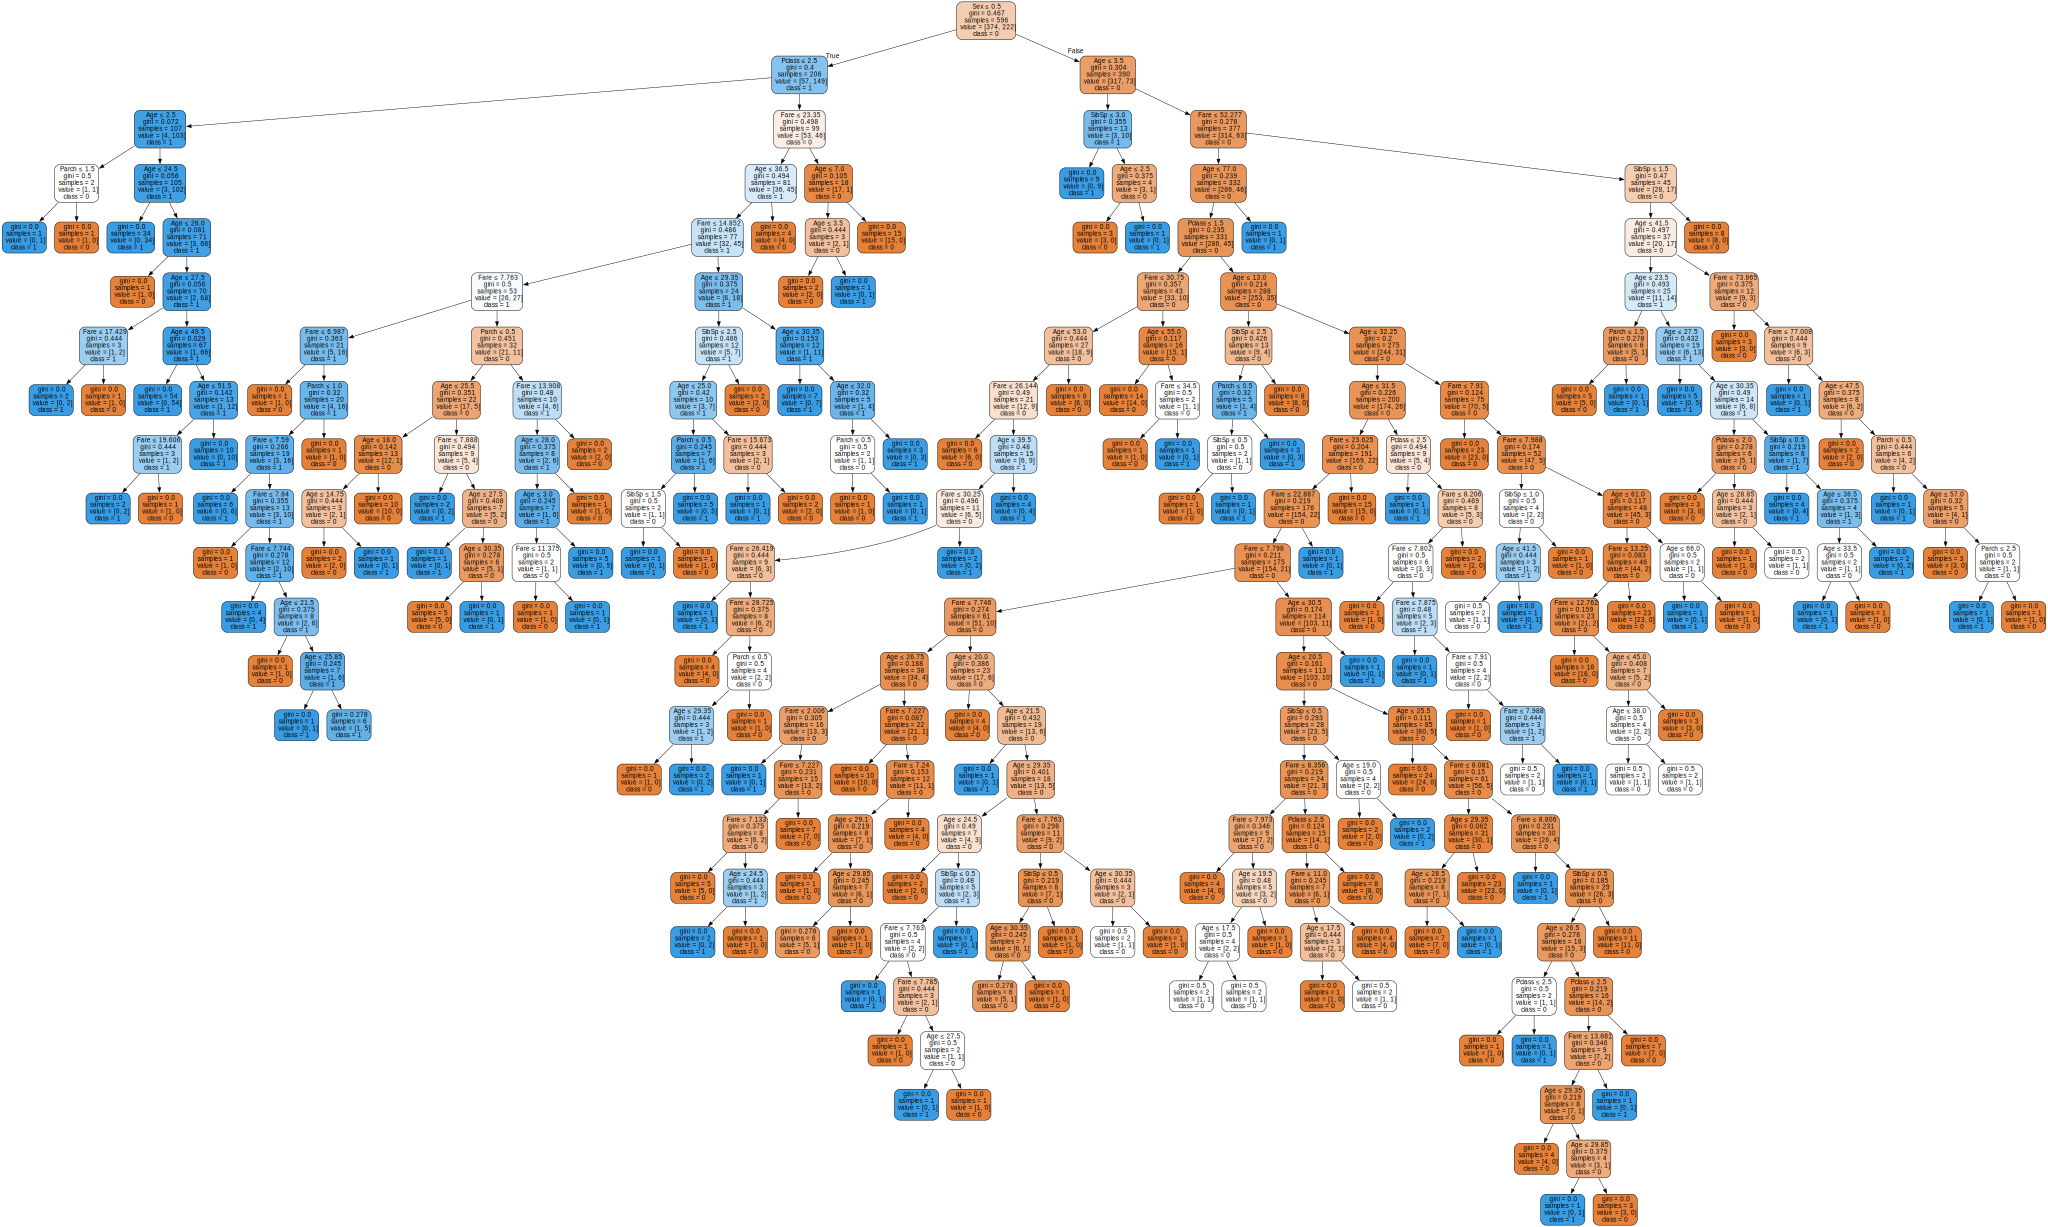

In [27]:
graph1

This is a very complex model, and if you zoom in you would see that in many leaves we have only 1 sample. this means that the model learned many complex rules to memorize the survival or death of each passenger in the training dat

Let's take Mr. Owen Harris (the first row of the training data), having such a complex model is similar to having a rule that says that if a passenger is in class 3, and is a male, and his age is more than 21, and his age is less than 23, and his fare is more than 7, and his fare is less than 8, and he has a sibling/spouse on board with him but no parents/children, then he would not survive. But this is obviously a rule that was tailor made to Mr Harris, and is equivalent to simply saying "Mr Harris did not survive", a rule that cannot be generalized to new unseen passengers who are not Mr Harris.

### Improve the model

reduce overfitting by limiting the number of "questions" that the model is allowed to ask. as each node in the tree is a question, by limiting the depth of the tree we can limit the number of questions. So let us again create an instance of a decision tree, but this one cannot produce trees deeper than 3 (3 questions):

In [28]:
model_improved = DecisionTreeClassifier(max_depth = 3)
model_improved.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [29]:
print('train score...' , accuracy_score(y_train, model_improved.predict(X_train)))
print('test score...', accuracy_score(y_test, model_improved.predict(X_test)))

train score... 0.8238255033557047
test score... 0.8203389830508474


In [30]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(model_improved, X_train, y_train, cv=10, scoring='accuracy')
print('Avarage train score...' , cv_score.mean())
print('Std train score...' , cv_score.std())

Avarage train score... 0.8171751412429378
Std train score... 0.07624102772646354


In [31]:
cv_score

array([0.66666667, 0.83333333, 0.91666667, 0.91666667, 0.76666667,
       0.76666667, 0.83050847, 0.84745763, 0.74576271, 0.88135593])

In [33]:
from sklearn.model_selection import cross_val_score
for depth in range(2, 6):
    print('With depth:',depth)
    cv_score = cross_val_score(DecisionTreeClassifier(max_depth = depth, max_features = None),
    X_train, y_train, cv=10, scoring='accuracy')
    print(' Avarage train score...' , cv_score.mean())
    print(' Std train score...' , cv_score.std())

With depth: 2
 Avarage train score... 0.8036158192090396
 Std train score... 0.0533085801506073
With depth: 3
 Avarage train score... 0.8171751412429378
 Std train score... 0.07624102772646354
With depth: 4
 Avarage train score... 0.7903672316384182
 Std train score... 0.05915020176786144
With depth: 5
 Avarage train score... 0.793587570621469
 Std train score... 0.05713971485708289


We can see that while the train score went down, the test score has improved and it is now almost as high as the train score. This means that the model does not overfit as badly anymore. 82% accuracy with such a simple model is quite impressive in my opinion.

Let's visualize the tree again using the same code snippet from above:

In [34]:
dot_data= export_graphviz(model_improved, out_file=None,impurity=False,
feature_names=X_test.columns,
class_names=['0', '1'],
filled=True, rounded=True)

In [35]:
graph2=graphviz.Source(dot_data)

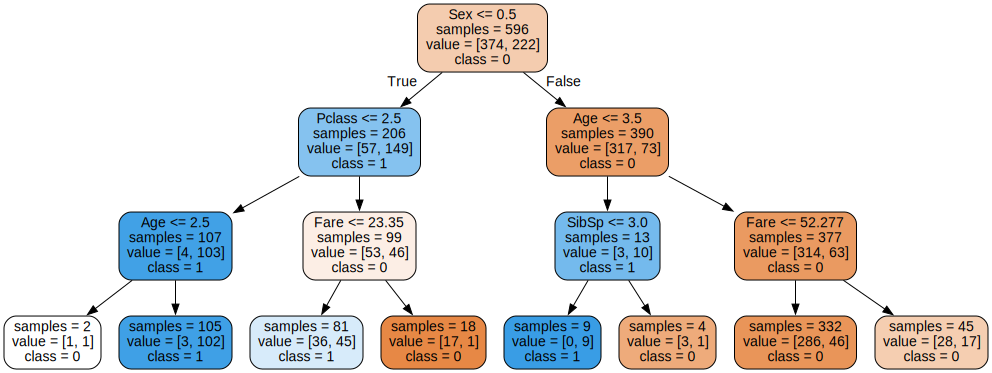

In [36]:
graph2

The training is the process of finding the most important features, and then use them to split the data. The training algorithm found that the most important features is the Sex. secondly, the class for females, and age for males. the bluer the block is, the higher the survival rate is, and opoositely with browner blocker.

### Optimisation

**GridSearchCV with Decision Tree Classifier**

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':[i for i in range(2, 6)],
'criterion':['gini', 'entropy'],
'max_features':['auto', 'sqrt', 'log2', None]}


In [40]:
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, verbose=2, scoring='accuracy')

In [43]:
clf.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=auto; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max_features=sqrt; total time=   0.0s
[CV] END .....criterion=gini, max_depth=2, max

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2', None]},
             scoring='accuracy', verbose=2)

In [44]:
print('Best Hyperparameters:', clf.best_params_)
print('Score:', clf.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': None}
Score: 0.8188418079096044


In [45]:
print('train score...' , accuracy_score(y_train, clf.predict(X_train)))
print('test score...', accuracy_score(y_test, clf.predict(X_test)))

train score... 0.8238255033557047
test score... 0.8203389830508474


**GridSearchCV with Random Forest Classifier**

In [46]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators':[i for i in range(10, 110, 10)],
'max_depth':[i for i in range(2, 6)],
'criterion':['gini', 'entropy'],
'max_features':['auto', 'sqrt', 'log2', None]}

In [47]:
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, verbose=2, scoring='accuracy')
clf.fit(X_train, y_train)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10; total time=   0.0s
[CV] 

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='accuracy', verbose=2)

In [48]:
print('Best Hyperparameters:', clf.best_params_)
print('Score:', clf.best_score_)
print('train score...' , accuracy_score(y_train, clf.predict(X_train)))
print('test score...', accuracy_score(y_test, clf.predict(X_test)))

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 90}
Score: 0.8304519774011299
train score... 0.8573825503355704
test score... 0.8169491525423729
